# Automatic Summarization
## Step 1
Narrow the corpus down to a selection pool of reasonable size for summary generation. The approaches compared are:
1. Random
2. Verified User
3. Engagements
4. TF-IDF Rank
5. Clustering
6. Noun Phrase (NP+V+NP)
7. Likely Event Model

Issues present in summaries
* uninformative documents
  * do not contain event updates or statistics etc.
* low quality documents
  * opinionated comments
  * questions
  * overused punctuation, capital letters
  * negative language
* documents concentrated at one time (as seen in tf-idf)

## Step 2
Perform state of the art temporal-novelty selection on each selection pool

1. TF-IDF Centroid Distance
2. K-Terms

## Evaluate
1. information gain
    *  unique terms
2. manual event annotation

#### import tools

In [1]:
import pandas as pd
import numpy as np

import nltk
from nltk import TweetTokenizer
import string
from collections import Counter

import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline

from time import time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

#### import data

In [3]:
df = pd.read_table('data/final/event_indianaprimary_data.txt', sep='\t', encoding='utf-8', header=0, low_memory=False)
df.shape

(54162, 29)

In [4]:
df.loc[:,('created_at')] = pd.to_datetime(df['created_at'])

In [6]:
#remove links
df['text_clean'] = df['text'].apply(lambda text: ' '.join([(w[:w.find('http')] if 'http' in w else w) for w in text.split()]))

#remove hashtag symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('#', ''))

#remove mention symbol
df['text_clean'] = df['text_clean'].apply(lambda text: text.replace('@', ''))

#initiate, apply tokenization
tknzr = TweetTokenizer()
df['text_clean'] = df['text_clean'].apply(lambda s: ' '.join([w.lower() for w in tknzr.tokenize(str(s))]))

#### define k docs
- summarize using 10 doc selection

In [263]:
k_docs = 100

#### random sample of 1k
- for testing algorithms
- filter retweets, replies from data

In [260]:
df_smpl = df[(df['is_retweet'] == False) & (df['is_reply'] == False)].sample(1000, random_state=2016)
#sort values for selection
df_smpl.sort_values(by='created_at', ascending=True, inplace=True)
#reset index for merging calcs
df_smpl.reset_index(drop=True, inplace=True)

#### define timeseries bounds

In [261]:
timeseries = pd.date_range(df['created_at'].min().strftime('%Y-%m-%d %H'), df['created_at'].max().strftime('%Y-%m-%d %H'), freq='H')

# visualize selections over time

In [299]:
d_total = df.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_total = d_total.reindex(timeseries, fill_value=0)
d_total['percent'] = d_total['count'].apply(lambda c: round(c/d_total['count'].sum() * 100, 2))
d_total['corpus'] = 'total'

In [300]:
d_smpl = df_smpl.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_smpl = d_smpl.reindex(timeseries, fill_value=0)
d_smpl['percent'] = d_smpl['count'].apply(lambda c: round(c/d_smpl['count'].sum() * 100, 2))
d_smpl['corpus'] = 'sample 1k'

In [301]:
d = pd.concat([d_total, d_smpl])

corpus
sample 1k    Axes(0.125,0.125;0.775x0.775)
total        Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

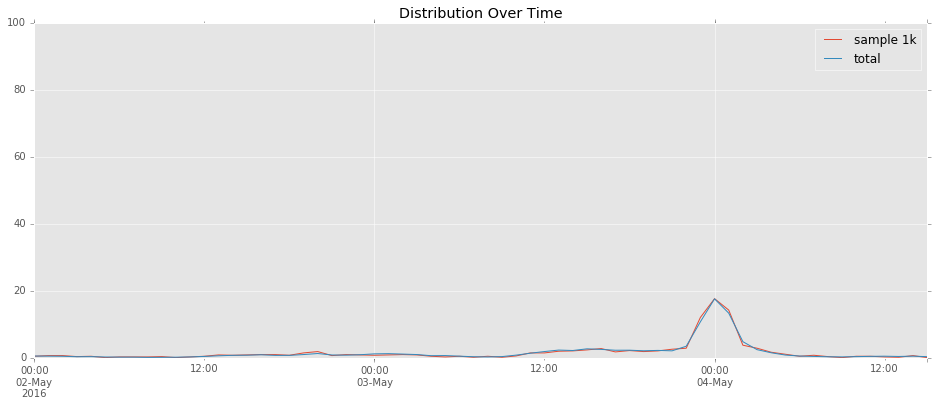

In [302]:
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [308]:
d_rndm = df_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_rndm = d_rndm.reindex(timeseries, fill_value=0)
d_rndm['percent'] = d_rndm['count'].apply(lambda c: round(c/d_rndm['count'].sum() * 100, 2))
d_rndm['corpus'] = 'k-doc random'

In [309]:
d_veri = df_veri.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_veri = d_veri.reindex(timeseries, fill_value=0)
d_veri['percent'] = d_veri['count'].apply(lambda c: round(c/d_veri['count'].sum() * 100, 2))
d_veri['corpus'] = 'k-doc verified'

In [310]:
d_eng = df_eng.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_eng = d_eng.reindex(timeseries, fill_value=0)
d_eng['percent'] = d_eng['count'].apply(lambda c: round(c/d_eng['count'].sum() * 100, 2))
d_eng['corpus'] = 'k-doc engagements'

corpus
k-doc engagements    Axes(0.125,0.125;0.775x0.775)
k-doc random         Axes(0.125,0.125;0.775x0.775)
k-doc verified       Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

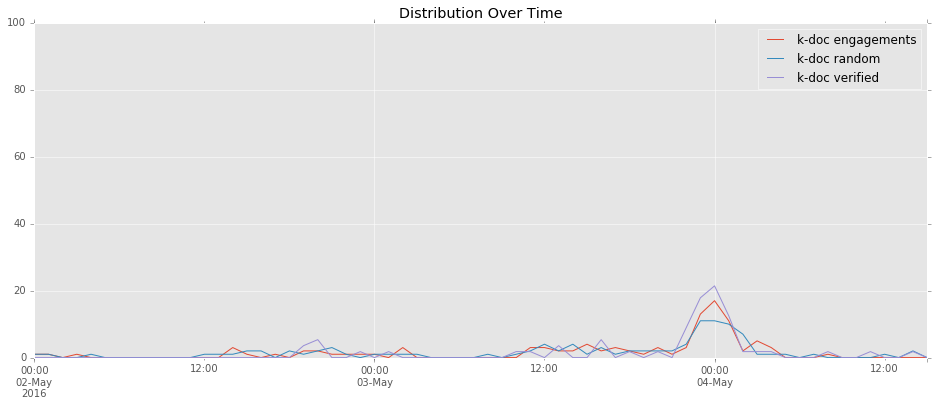

In [311]:
d = pd.concat([d_rndm, d_veri, d_eng])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [312]:
d_tfidf = df_tfidf.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf = d_tfidf.reindex(timeseries, fill_value=0)
d_tfidf['percent'] = d_tfidf['count'].apply(lambda c: round(c/d_tfidf['count'].sum() * 100, 2))
d_tfidf['corpus'] = 'k-doc tfidf'

In [313]:
d_tfidf_stpd = df_tfidf_stpd.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_stpd = d_tfidf_stpd.reindex(timeseries, fill_value=0)
d_tfidf_stpd['percent'] = d_tfidf_stpd['count'].apply(lambda c: round(c/d_tfidf_stpd['count'].sum() * 100, 2))
d_tfidf_stpd['corpus'] = 'k-doc tfidf stopped'

In [314]:
d_tfidf_clnd = df_tfidf_clnd.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_clnd = d_tfidf_clnd.reindex(timeseries, fill_value=0)
d_tfidf_clnd['percent'] = d_tfidf_clnd['count'].apply(lambda c: round(c/d_tfidf_clnd['count'].sum() * 100, 2))
d_tfidf_clnd['corpus'] = 'k-doc tfidf cleaned'

In [315]:
d_tfidf_adj = df_tfidf_adj.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_tfidf_adj = d_tfidf_adj.reindex(timeseries, fill_value=0)
d_tfidf_adj['percent'] = d_tfidf_adj['count'].apply(lambda c: round(c/d_tfidf_adj['count'].sum() * 100, 2))
d_tfidf_adj['corpus'] = 'k-doc tfidf adjusted'

corpus
k-doc tfidf             Axes(0.125,0.125;0.775x0.775)
k-doc tfidf adjusted    Axes(0.125,0.125;0.775x0.775)
k-doc tfidf cleaned     Axes(0.125,0.125;0.775x0.775)
k-doc tfidf stopped     Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

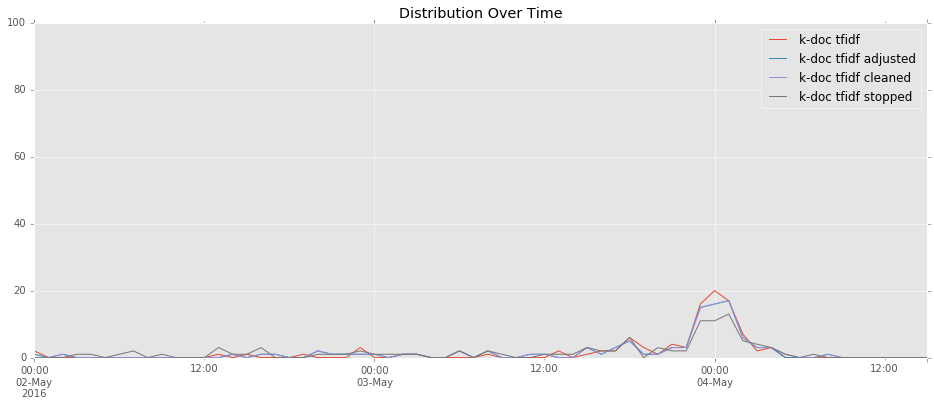

In [316]:
d = pd.concat([d_tfidf, d_tfidf_stpd, d_tfidf_clnd, d_tfidf_adj])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [317]:
d_clust_first = df_clust_first.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_first = d_clust_first.reindex(timeseries, fill_value=0)
d_clust_first['percent'] = d_clust_first['count'].apply(lambda c: round(c/d_clust_first['count'].sum() * 100, 2))
d_clust_first['corpus'] = 'k-doc cluster first'

In [318]:
d_clust_last = df_clust_last.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_last = d_clust_last.reindex(timeseries, fill_value=0)
d_clust_last['percent'] = d_clust_last['count'].apply(lambda c: round(c/d_clust_last['count'].sum() * 100, 2))
d_clust_last['corpus'] = 'k-doc cluster last'

In [319]:
d_clust_wght = df_clust_wght.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_clust_wght = d_clust_wght.reindex(timeseries, fill_value=0)
d_clust_wght['percent'] = d_clust_wght['count'].apply(lambda c: round(c/d_clust_wght['count'].sum() * 100, 2))
d_clust_wght['corpus'] = 'k-doc cluster weighted'

corpus
k-doc cluster first       Axes(0.125,0.125;0.775x0.775)
k-doc cluster last        Axes(0.125,0.125;0.775x0.775)
k-doc cluster weighted    Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

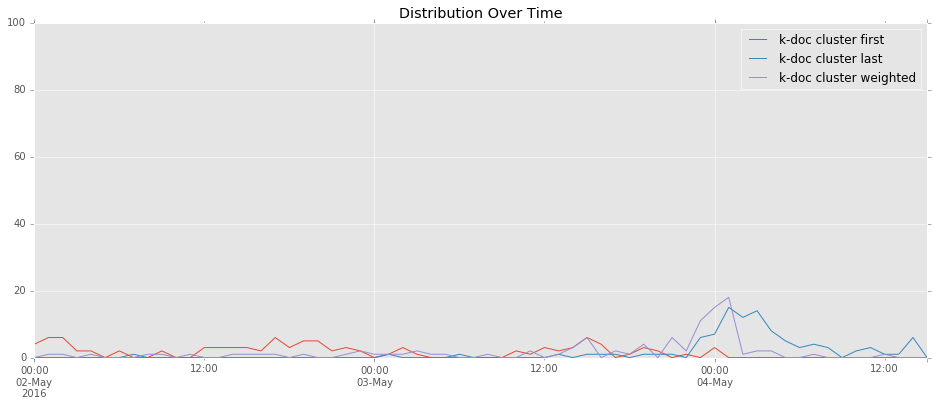

In [320]:
d = pd.concat([d_clust_first, d_clust_last, d_clust_wght])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

In [322]:
d_NPV_rndm = df_NPV_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_NPV_rndm = d_NPV_rndm.reindex(timeseries, fill_value=0)
d_NPV_rndm['percent'] = d_NPV_rndm['count'].apply(lambda c: round(c/d_NPV_rndm['count'].sum() * 100, 2))
d_NPV_rndm['corpus'] = 'k-doc noun phrase + verb'

In [323]:
d_NPVNP_rndm = df_NPVNP_rndm.set_index('created_at').groupby([pd.TimeGrouper(freq='H')])['twitter_id'].agg(['count'])
d_NPVNP_rndm = d_NPVNP_rndm.reindex(timeseries, fill_value=0)
d_NPVNP_rndm['percent'] = d_NPVNP_rndm['count'].apply(lambda c: round(c/d_NPVNP_rndm['count'].sum() * 100, 2))
d_NPVNP_rndm['corpus'] = 'k-doc noun phrase + verb + noun phrase'

corpus
k-doc noun phrase + verb                  Axes(0.125,0.125;0.775x0.775)
k-doc noun phrase + verb + noun phrase    Axes(0.125,0.125;0.775x0.775)
Name: percent, dtype: object

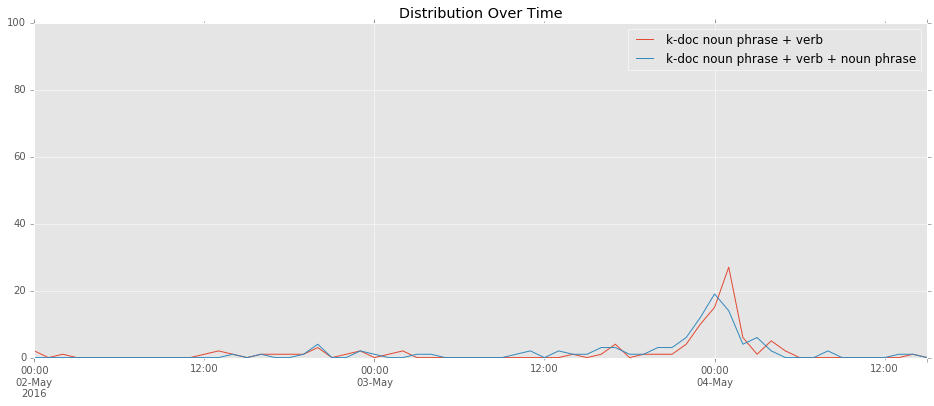

In [324]:
d = pd.concat([d_NPV_rndm, d_NPVNP_rndm])
d.groupby('corpus')['percent'].plot(figsize=(16,6),
                                    ylim=(0,100),
                                    legend=True,
                                    title='Distribution Over Time')

# Step 1
## 1. Random Selection
### method:
Select k random documents from corpus

In [264]:
df_rndm = df_smpl.sample(k_docs, random_state=2016)
summ = df_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 01:38:09	#indianaprimary Clint Eastwood  ENDORSES Donald J. Trump for President Of The United States.  SHUT UP https://t.co/vqQBCDRVJy
2016-05-02 04:41:14	Still Report #834 - #TedCruz Bails on #Indiana https://t.co/SYYJqhgZKp #INPrimary #IndianaPrimary #MakeAmericaGreatAgain #Trump2016
2016-05-02 12:28:38	MT @Karee_news: #IndianaPrimary #Conservatives across this land are counting you to #ChooseCruz. https://t.co/WtejAoKMRK #CruzCrew #PJNET
2016-05-02 13:23:14	#IndianaPrimary Preview @crousselle @townhallcom https://t.co/uY7xllZqjF
2016-05-02 14:27:33	@NYT DANGEROUS Donald  https://t.co/fpwSvARj9i European leaders: Another Hitler. Exceed Hillary, Obma making US worse  #Cruz #IndianaPrimary
2016-05-02 15:16:37	#NeverTrump bought favors from establishment in the White House. Is he also buying this election? #IndianaPri

## 2. Verified User Selection
### method:
Select k random docs from verified users

In [270]:
df_veri = df_smpl[df_smpl['user_verified'] == True].sample(min(k_docs, df_smpl[df_smpl['user_verified'] == True].shape[0]), random_state=2016)
summ = df_veri.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 19:35:18	Live now on @facebook. Ask me a question &gt; https://t.co/wdKdBxA0Be #IndianaPrimary
2016-05-02 19:48:01	Indiana's strict #voterID law was upheld by #scotus in 2008. What to know about #voterID: https://t.co/PfjpZ2Hg59 #IndianaPrimary
2016-05-02 20:04:00	I dont get how someone can be that nasty. At least @tedcruz had the 🏐⚽️🏀 to face/visit the crowd. #IndianaPrimary
2016-05-02 20:32:41	WATCH NOW: Trump speaks at a rally in Carmel, Ind. ahead of #IndianaPrimary https://t.co/2fyNEZG6NI https://t.co/nZZLCgppJ0
2016-05-02 20:41:27	Another coach backs @realdonaldtrump - Former @NDFootball's Lou Holtz backing #GOP front-runner ahead of #IndianaPrimary
2016-05-02 23:32:30	In South Bend, where @tedcruz needs strong vote, @realDonaldTrump draws SRO to Century Center. #IndianaPrimary https://t.co/B98cTeqbpd
2016-05-03 01:38:51	On the brink of the nomination, Donald tones down the Trump. @GriffinLeeds before the #IndianaPrimary https://t.co/ZQ9wImMpqU via @TheTab
2016-05-03 1

## 3. Engagements Selection
### method:
Select k docs with highest engagements

In [272]:
df_smpl['engagements'] = df_smpl['favorite_count'] + df_smpl['retweet_count']

In [273]:
df_eng = df_smpl.sort_values(by='engagements', ascending=False).head(k_docs)
summ = df_eng.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:25:34	Limbaugh: Ted Cruz Is ‘Inarguably Thoroughbred Conservative’ [VIDEO] https://t.co/0OVrmj16zm  #RedNationRising #Indianaprimary #CruzCrew
2016-05-02 01:43:17	.@realDonaldTrump whoops, look what I found,MSM! #IndianaPrimary #Trump2016 #TrumpTrain #Indiana #Hoosiers4Trump https://t.co/TxGaI6jCQZ
2016-05-02 03:22:56	Carly drops like a rock, just like Ted's chances of the nomination. #Trump2016 #IndianaPrimary #CaliforniaPrimary https://t.co/hxNPpQxQ84
2016-05-02 14:02:47	#Kasich is not good for Ohio. Not good for U.S. #VOTETRUMP #INDIANAPRIMARY @TeamJohnKasich should drop now https://t.co/4AxouLzHvw
2016-05-02 14:40:04	Breaking News: @realDonaldTrump has won NOTHING! He hasn't won the GOP nomination &amp; won't. Stop listening to propaganda! :) #IndianaPrimary
2016-05-02 14:59:10	#IN #IndianaPrimary #Veterans Ask You 2Vote 4 Trump►https://t.co/ynfAYFQRPC @AbnInfVet @Vets4TrumpORG @KamVTV #USA🇺🇸 https://t.co/fI8yRPpA6T
2016-05-02 15:50:10	Indiana we get to put this race 

## 4. TF-IDF Rank
### method:
Computes weights for each document using term frequencies and selects k best documents. The term frquency inverse document frequency equation computes a term importance which is higher if the term is frequent in one document but rare in the total corpus.

In [274]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer()
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 3443


In [275]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [276]:
df_tfidf = df_smpl.sort_values(by='tfidf_sum', ascending=False).head(k_docs)
summ = df_tfidf.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 00:33:59	We already know when #Trump wins huge in #IndianaPrimary, @tedcruz will posit the #CaliforniaPrimary hinges on everything. Rinse and repeat.
2016-05-02 13:46:46	I am very happy to see Indiana Gov. Mike Pence's endorsement of Ted Cruz. Let's win on Tuesday!  #IndianaPrimary... https://t.co/T2RzFFlcia
2016-05-02 15:50:10	Indiana we get to put this race away for @realDonaldTrump &amp; send a "YUGE" message to @tedcruz to drop out #VoteTrump in the #indianaprimary
2016-05-02 19:03:49	#IndianaPrimary..Hillary's Bosnia 'sniper fire' fable dishonors all who have come under fire..she will forever be known as a valor thief.
2016-05-02 23:13:35	With just one day left to know the #IndianaPrimary outcome, it's all but certain that it's every candidates primary to lose. #trump #Cruz
2016-05-02 23:17:35	Voting in the #Ind

#### tfidf stopped

In [277]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 3235


In [278]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_stpd_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [279]:
df_tfidf_stpd = df_smpl.sort_values(by='tfidf_stpd_sum', ascending=False).head(k_docs)
summ = df_tfidf_stpd.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 03:00:52	LYIN DON: JUST 101 OF #TRUMP 'S MANY LIES   https://t.co/H9TivUVTAK |#CAPrimary #IndianaPrimary #INPrimary #NEPrimary #WAPrimary #NMPrimary
2016-05-02 04:36:51	Watch "Judge Jeanine &amp; Bobby Knight  Donald Trump 4/30 https://t.co/PRNxJyXYXe #IndianaPrimary #Indiana  #INPrimary https://t.co/9P5u0ymbcT
2016-05-02 06:35:42	#CCOT Muslims And Pro-Homosexual Agents To Stop Trump &amp; Cause Riots &amp; Violence Throughout U.S. https://t.co/Mz9HqVpxwg #IndianaPrimary
2016-05-02 07:19:41	VOTE  #TRUMP 🚂💨 #WV #NE #INDIANA #OR #WA #CA #IndianaPrimary 🚂💨 #TedCruz Lies 10TimesIn5mins https://t.co/r4tHI6QL6m https://t.co/vZa6qLTwMB
2016-05-02 07:23:42	VOTE  #TRUMP 🚂💨 #WV #NE #INDIANA #OR #WA #CA #IndianaPrimary 🚂💨 #TedCruz Lies 10TimesIn5mins https://t.co/r4tHI6zaeO https://t.co/In5fjUi4sh
2016-05-02 09:12:02	Four new ads airing in Indiana https://t.co/j7N60aCV6Z via @LegInsurrection #tcot #gop #ccot #INpol #INPrimary #IndianaPrimary #ChooseCruz
2016-05-02 13:43:29	Donald Trump

#### tfidf cleaned

In [280]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 2705


In [281]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_clnd_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [282]:
df_tfidf_clnd = df_smpl.sort_values(by='tfidf_clnd_sum', ascending=False).head(k_docs)
summ = df_tfidf_clnd.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 02:43:49	Making calls to #Hoosiers tomorrow to vote for #Trump2016 #IndianaPrimary #HoosiersForTrump Voice getting a little raspy already
2016-05-02 14:27:33	@NYT DANGEROUS Donald  https://t.co/fpwSvARj9i European leaders: Another Hitler. Exceed Hillary, Obma making US worse  #Cruz #IndianaPrimary
2016-05-02 16:19:57	New poll finds #Cruz with double-digit lead in #IndianaPrimary   https://t.co/qqu2TExgvb #CruzCrew #TrumpTrain #GOP2016 #TCOT
2016-05-02 17:28:50	Hey @HillaryClinton - let's go to Talor's Bakery in Fishers and eat sugar cookies and donies together!!! #IndianaPrimary #pleaseeeee
2016-05-02 20:11:27	#Commie Economist Robert Reich: #TedCruz uses a Clear Script and a Carefully Crafted Strategy! #IndianaPrimary
2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIANA child for yelling 2 words IGNORE 100's of worse Protests.
2016-05-02 21:10:27	#Indiana  Liberals R funding #Cruz 2weaken #GOP! Don't help Puppet #LyinTed!  #V

#### tfidf adjusted

In [283]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.99, stop_words='english')
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.001000s
n_samples: 1000, n_features: 2704


In [284]:
#get sum tfidf for each doc
Xtfidf_sums = Xtfidf.sum(axis=1)
df_tfidf_sums = pd.DataFrame(Xtfidf_sums, columns=['tfidf_adj_sum'])

df_smpl = pd.merge(df_smpl, df_tfidf_sums, left_index=True, right_index=True)

In [285]:
df_tfidf_adj = df_smpl.sort_values(by='tfidf_adj_sum', ascending=False).head(k_docs)
summ = df_tfidf_adj.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 02:43:49	Making calls to #Hoosiers tomorrow to vote for #Trump2016 #IndianaPrimary #HoosiersForTrump Voice getting a little raspy already
2016-05-02 14:27:33	@NYT DANGEROUS Donald  https://t.co/fpwSvARj9i European leaders: Another Hitler. Exceed Hillary, Obma making US worse  #Cruz #IndianaPrimary
2016-05-02 16:19:57	New poll finds #Cruz with double-digit lead in #IndianaPrimary   https://t.co/qqu2TExgvb #CruzCrew #TrumpTrain #GOP2016 #TCOT
2016-05-02 17:28:50	Hey @HillaryClinton - let's go to Talor's Bakery in Fishers and eat sugar cookies and donies together!!! #IndianaPrimary #pleaseeeee
2016-05-02 20:11:27	#Commie Economist Robert Reich: #TedCruz uses a Clear Script and a Carefully Crafted Strategy! #IndianaPrimary
2016-05-02 20:48:55	@deneenborelli #IndianaPrimary VOTE for #Trump fight BS MSM picking on 1  INDIA

## 5. Cluster Selection
### method:
Cluster documents, select k docs / k clusters from each cluster, for an evenly distributed information pool.

In [286]:
t0 = time()
#initialize sklearn vectorizer
tfidf_vectorizer = TfidfVectorizer()
print("done in %fs" % (time() - t0))

#create matrix of tfidf counts
Xtfidf = tfidf_vectorizer.fit_transform(df_smpl['text_clean'])
print("n_samples: %d, n_features: %d" % Xtfidf.shape)

done in 0.000000s
n_samples: 1000, n_features: 2912


In [287]:
km = KMeans(n_clusters=k_docs, random_state=2016)

In [288]:
t0 = time()
km.fit(Xtfidf)
print("done in %fs" % (time() - t0))

done in 1.774337s


In [289]:
dfclust = pd.DataFrame(km.labels_, columns=['cluster'])

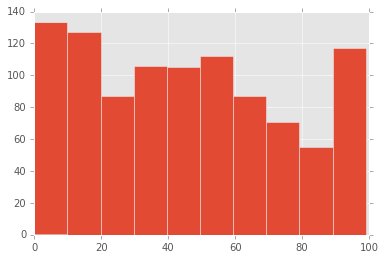

In [290]:
dfclust['cluster'].hist()

In [291]:
df_smpl = pd.merge(df_smpl, dfclust, left_index=True, right_index=True)

#### cluster first

In [292]:
df_clust_first = df_smpl.groupby('cluster').first()
summ = df_clust_first.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 00:25:34	Limbaugh: Ted Cruz Is ‘Inarguably Thoroughbred Conservative’ [VIDEO] https://t.co/0OVrmj16zm  #RedNationRising #Indianaprimary #CruzCrew
2016-05-02 00:30:43	🚨#Bernie WINS when voter turnout is #YUGE Find Polls ☑https://t.co/8GMbIaoSqf #VoteBernie #IndianaPrimary #INPrimary https://t.co/Ez5TdlDC32
2016-05-02 00:33:59	We already know when #Trump wins huge in #IndianaPrimary, @tedcruz will posit the #CaliforniaPrimary hinges on everything. Rinse and repeat.
2016-05-02 01:11:48	It all comes to the Crossroads of America! #IndianaPrimary #INPrimary #INPrimary2016 #Indianoplace
2016-05-02 01:18:53	🎯 Mike Pence: Why I will vote for @TedCruz #IndianaPrimary https://t.co/sJ5Na3afHk
2016-05-02 01:38:09	#indianaprimary Clint Eastwood  ENDORSES Donald J. Trump for President Of The United States.  SHUT UP https://t.co/vqQ

#### cluster last

In [293]:
df_clust_last = df_smpl.groupby('cluster').last()
summ = df_clust_last.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 07:23:42	VOTE  #TRUMP 🚂💨 #WV #NE #INDIANA #OR #WA #CA #IndianaPrimary 🚂💨 #TedCruz Lies 10TimesIn5mins https://t.co/r4tHI6zaeO https://t.co/In5fjUi4sh
2016-05-03 01:52:02	https://t.co/Pv13s1WV0e Donate! Volunteer! #ImWithHer #EstoyConHillary #womancard #IndianaPrimary #womancard https://t.co/iOuRVUvhyn
2016-05-03 06:52:02	#Indiana  Liberals R funding #Cruz 2weaken #GOP #LyinTed = Dem Puppet!  #VoteTrump #INPrimary #IndianaPrimary #MAGA https://t.co/unmeArAD8y
2016-05-03 13:56:50	#CAPrimary #CaliforniaPrimary #CA #California #INPrimary #IndianaPrimary #IN #Indiana  STOP EST INSURRECTION ON🇺🇸🗽🇵🇷 https://t.co/XwMX9RTWR3
2016-05-03 15:01:10	#Indiana #INPrimary #IndianaPrimary #Indianapolis CRUZ'S  Plan offers GREAT Tax Relief 4 families! https://t.co/tE460SWxTv
2016-05-03 16:45:24	Trump Says Cruz's Dad Shouldn't Be Allowed to Talk About Religion #IndianaPrimary  https://t.co/Hlw8HPTnQ4
2016-05-03 17:23:54	MT @Karee_news: #IndianaPrimary #Conservatives across this land are countin

#### cluster weight random

In [294]:
dfclust_weights = pd.DataFrame(dfclust['cluster'].value_counts(normalize=True)).reset_index()
dfclust_weights.columns = [['cluster', 'cluster_weight']]

In [295]:
df_smpl = pd.merge(df_smpl, dfclust_weights, how='left', on='cluster')

In [296]:
df_clust_wght = df_smpl.sample(k_docs, weights='cluster_weight', random_state=2016)
summ = df_clust_wght.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + ' ' + str(doc['cluster']) + '\t' + doc['text'])

2016-05-02 01:43:17 68	.@realDonaldTrump whoops, look what I found,MSM! #IndianaPrimary #Trump2016 #TrumpTrain #Indiana #Hoosiers4Trump https://t.co/TxGaI6jCQZ
2016-05-02 02:03:45 11	Poll: Ted Cruz leads Donald Trump in Indiana https://t.co/FKWoWge7Q8  #UniteWithCruzFiorina  #IndianaPrimary #INPrimary
2016-05-02 04:26:46 12	Bernie Rally will be in Evansville on Monday #Indiana #IndianaPrimary #IndianaPoll #Indianapolis #Evansville  https://t.co/SvK3fYFyVV
2016-05-02 08:37:59 42	Hannity Interview with @TedCruz &amp; @CarlyFiorina | April 29, 2016 | #CruzCarly2016: #IndianaVoters #IndianaPrimary https://t.co/V9ymvA8Rb0
2016-05-02 09:12:02 42	Four new ads airing in Indiana https://t.co/j7N60aCV6Z via @LegInsurrection #tcot #gop #ccot #INpol #INPrimary #IndianaPrimary #ChooseCruz
2016-05-02 11:28:58 90	🚂🚃🚃🚃🚃🚃🚃🚃🇺🇸 #IN #Indiana #IndianaPrimary Trump #Trump #Trump2016 #TrumpTrain #VoteTrump #MAGA #PrimaryDay https://t.co/dMkydOzyQe
2016-05-02 14:59:10 1	#IN #IndianaPrimary #Veterans Ask You 2

## 6. Noun Phrases
### method:
using off the shelf nlp tool NLTK, POS tag and chunk tweets looking for noun phrases and verbs

In [297]:
def event_check_NPV(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    last = ('','')
    event = 0
    for item in pos:
        #if last was noun
        if last[1][0:2] == 'NN':
            #check for verb
            if item[1][0] == 'V':
                event = 1
        last = item
    return event

In [298]:
%%time
df_smpl['event_NPV'] = df_smpl['text'].apply(lambda text: event_check_NPV(text))

Wall time: 2min 39s


In [304]:
df_NPV_rndm = df_smpl[df_smpl['event_NPV'] == 1].sample(k_docs, random_state=2016)
summ = df_NPV_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 00:21:31	#IndianaPrimary..why would anyone pay $353K to dine with Hillary?..wealthy people view this 'donation' as an investment and demand a return.
2016-05-02 00:30:43	🚨#Bernie WINS when voter turnout is #YUGE Find Polls ☑https://t.co/8GMbIaoSqf #VoteBernie #IndianaPrimary #INPrimary https://t.co/Ez5TdlDC32
2016-05-02 02:14:59	Pretty sure that lyin' @tedcruz is cheering for the Raptors right now since he's Canadian #IndianaPrimary
2016-05-02 12:28:38	MT @Karee_news: #IndianaPrimary #Conservatives across this land are counting you to #ChooseCruz. https://t.co/WtejAoKMRK #CruzCrew #PJNET
2016-05-02 13:14:25	A vote for #Trump is a vote for Hillary. #ChooseCruz #INPrimary #IndianaPrimary
2016-05-02 13:59:48	Donald Trump reveals the struggles that kept his faith in Jesus strong https://t.co/3NoPFI61Xm #rnc #gop #IndianaPrimary #2016election
2016-05-02 14:27:33	@NYT DANGEROUS Donald  https://t.co/fpwSvARj9i European leaders: Another Hitler. Exceed Hillary, Obma making US worse  

In [305]:
grammar = """NBAR: {<NN.*|JJ>*<NN.*>} 
NP: {<NBAR>} 
{<NBAR><IN><NBAR>}"""
cp = nltk.RegexpParser(grammar)

In [306]:
def event_check_NPVNP(text):
    tokens = nltk.word_tokenize(text)
    pos = nltk.pos_tag(tokens)
    result = cp.parse(pos)

    structure = [node[1] if type(node) != nltk.Tree else 'NP' for node in result]
    ls = [t[0] for t in structure]

    NP = False
    NP_V = False
    NP_V_NP = 0
    for t in ls:
        if NP_V == True and t == 'N':
            NP_V_NP = 1
        elif NP_V == True and t not in ['N','V']:
            NP = False
            NP_V = False
        if NP == True and t == 'V':
            NP_V = True
        if t == 'N':
            NP = True
    return NP_V_NP

In [307]:
%%time
df_smpl['event_NPVNP'] = df_smpl['text'].apply(lambda text: event_check_NPVNP(text))

Wall time: 2min 50s


In [321]:
df_NPVNP_rndm = df_smpl[df_smpl['event_NPVNP'] == 1].sample(k_docs, random_state=2016)
summ = df_NPVNP_rndm.sort_values(by='created_at', ascending=True)

for _,doc in summ.iterrows():
    print(str(doc['created_at']) + '\t' + doc['text'])

2016-05-02 14:40:04	Breaking News: @realDonaldTrump has won NOTHING! He hasn't won the GOP nomination &amp; won't. Stop listening to propaganda! :) #IndianaPrimary
2016-05-02 16:15:11	'You suck!' child yells; #TedCruz compares him to Donald Trump, offers lesson in respect, parenting https://t.co/WiP7f1sLTK #IndianaPrimary
2016-05-02 19:08:53	👀 @FoxNews right now w/ @tedcruz talking 2 these rude Trump supporters. In all fairness these ppl need 2 show respect. #IndianaPrimary
2016-05-02 20:17:34	The fact that people still support Hillary. That nasty, rape apologists! #Hillary4Prison2016 #IndianaPrimary  https://t.co/vgqxFBZ8hd
2016-05-02 20:33:46	@RichardWeaving Indiana, please vote for @realDonaldTrump tomorrow!  We need you all! https://t.co/MrTa5W4Lsc  #Trump2016  #IndianaPrimary
2016-05-02 20:39:12	.@TedCruz confronts #Trump supporter EPIC! .@realDonaldTrump takes YOU for chumps #IndianaPrimary #INPrimary #tcot https://t.co/zAASVsvfjc
2016-05-02 20:41:27	Another coach backs @realdona